In [1]:
# загрузка библиотек
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import *

import numpy as np
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint,EarlyStopping 
from tensorflow.keras import optimizers
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [62]:
# считывание данных. условия считывания - разделитель десятичных точка, разделитель столбцов запятая
path = 'C:/Users/user/Desktop/Employers/ServiceSoft(СофтИнжиниринг)/2_Для практического задания/'
#s = pd.read_csv(path + '4056_Nd_входящие данные дневные.csv', squeeze=True, encoding = "ISO-8859-1")
s = pd.read_csv(path + '4056_Nd данные для обучения.csv', squeeze=True, encoding = "ISO-8859-1")

In [63]:
s.shape

(896770, 2)

In [64]:
s = s.iloc[:10000]

In [65]:
s

,TimeValue,Value|Ìàêñèìóì
0,01.03.2019 0:00:09,194.281464
1,01.03.2019 0:01:10,189.149501
2,01.03.2019 0:02:10,185.483813
3,01.03.2019 0:03:10,187.683226
4,01.03.2019 0:04:10,186.216950
...,...,...
9995,08.03.2019 4:01:58,195.747739
9996,08.03.2019 4:02:58,195.014602
9997,08.03.2019 4:04:27,192.448620
9998,08.03.2019 4:05:57,193.548326


In [66]:
s.rename(columns={'Value|Ìàêñèìóì': 'Value'}, inplace=True)


In [67]:
# индексирование по времени
s.index = pd.to_datetime(s.TimeValue, dayfirst=True)

In [68]:
# перевод в серию интерполированную по 1 минуте
res = s.Value.resample('s').interpolate().resample('1T').asfreq().dropna()


In [69]:
# создание обрабатываемого набора и именование
resedit=res
resedit.name='Minus 1440 minut'

In [70]:
# создание и именование датафрейма скользящих окон
n=20
allres=[]
for i in range(1,73):
    res1=resedit.shift(periods=-n*i)
    res1.name='Minus '+str(1440 - n*i)+' minut'
    allres.append(res1)

for i in allres:
    resedit=pd.concat([resedit,i],axis=1)

In [71]:
resedit.shape

(10326, 73)

In [72]:
# создание дамми-параметров по месяцу и часу
resedit.insert(0,'Month',(resedit.index + timedelta(minutes=1680)).month)
resedit.insert(0,'Hour',(resedit.index + timedelta(minutes=1680)).hour)
resedit=pd.get_dummies(resedit,columns=['Month'])
resedit=pd.get_dummies(resedit,columns=['Hour'])

In [73]:
# подгонка под шаблон датафрейма для подачи в сеть 
c1 = ['Minus 1440 minut', 'Minus 1420 minut', 'Minus 1400 minut',
       'Minus 1380 minut', 'Minus 1360 minut', 'Minus 1340 minut',
       'Minus 1320 minut', 'Minus 1300 minut', 'Minus 1280 minut',
       'Minus 1260 minut', 'Minus 1240 minut', 'Minus 1220 minut',
       'Minus 1200 minut', 'Minus 1180 minut', 'Minus 1160 minut',
       'Minus 1140 minut', 'Minus 1120 minut', 'Minus 1100 minut',
       'Minus 1080 minut', 'Minus 1060 minut', 'Minus 1040 minut',
       'Minus 1020 minut', 'Minus 1000 minut', 'Minus 980 minut',
       'Minus 960 minut', 'Minus 940 minut', 'Minus 920 minut',
       'Minus 900 minut', 'Minus 880 minut', 'Minus 860 minut',
       'Minus 840 minut', 'Minus 820 minut', 'Minus 800 minut',
       'Minus 780 minut', 'Minus 760 minut', 'Minus 740 minut',
       'Minus 720 minut', 'Minus 700 minut', 'Minus 680 minut',
       'Minus 660 minut', 'Minus 640 minut', 'Minus 620 minut',
       'Minus 600 minut', 'Minus 580 minut', 'Minus 560 minut',
       'Minus 540 minut', 'Minus 520 minut', 'Minus 500 minut',
       'Minus 480 minut', 'Minus 460 minut', 'Minus 440 minut',
       'Minus 420 minut', 'Minus 400 minut', 'Minus 380 minut',
       'Minus 360 minut', 'Minus 340 minut', 'Minus 320 minut',
       'Minus 300 minut', 'Minus 280 minut', 'Minus 260 minut',
       'Minus 240 minut', 'Minus 220 minut', 'Minus 200 minut',
       'Minus 180 minut', 'Minus 160 minut', 'Minus 140 minut',
       'Minus 120 minut', 'Minus 100 minut', 'Minus 80 minut',
       'Minus 60 minut', 'Minus 40 minut', 'Minus 20 minut', 'Minus 0 minut',
       'Month_1','Month_2','Month_3','Month_4','Month_5','Month_6','Month_7','Month_8','Month_9','Month_10','Month_11','Month_12',
        'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5',
       'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12',
       'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18',
       'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23']
df_ = pd.DataFrame(columns=c1)
frames = [df_, resedit]
resedit = pd.concat(frames, sort=False)


In [74]:
# dfprog=res.shift(periods=-1680)

In [75]:
# создание колонки прогноза на 4 часа
dfprog=res.shift(periods=-1680)
dfprog.name='Prognoz 4 hour'               # прогноз со здвигом в 4 часа
dfopor=pd.concat([resedit,dfprog], axis=1) # dfopor

In [76]:
# создание колонок меток времени для старта и прогноза
dfopor['Data_Time_Start'] = dfopor.index + timedelta(minutes=1440)
dfopor['Data_Time_Prognoz'] = dfopor.index + timedelta(minutes=1680)

In [77]:
dfopor

,Minus 1440 minut,Minus 1420 minut,Minus 1400 minut,Minus 1380 minut,Minus 1360 minut,Minus 1340 minut,Minus 1320 minut,Minus 1300 minut,Minus 1280 minut,Minus 1260 minut,...,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,Prognoz 4 hour,Data_Time_Start,Data_Time_Prognoz
2019-03-01 00:01:00,189.990806,190.285864,189.552726,187.870583,187.512160,187.952043,187.023402,191.935424,193.914895,192.782239,...,0,0,0,0,0,0,0,192.082051,2019-03-02 00:01:00,2019-03-02 04:01:00
2019-03-01 00:02:00,186.094761,186.876774,189.259471,188.359341,188.330830,187.707664,189.589383,191.422227,192.937378,193.523614,...,0,0,0,0,0,0,0,193.059568,2019-03-02 00:02:00,2019-03-02 04:02:00
2019-03-01 00:03:00,187.316657,184.970616,187.903167,189.063968,186.473549,189.002873,189.222815,190.689090,193.487232,187.878729,...,0,0,0,0,0,0,0,193.914895,2019-03-02 00:03:00,2019-03-02 04:03:00
2019-03-01 00:04:00,186.461330,188.489677,186.436892,188.501896,188.159765,187.829853,187.829853,189.955952,191.532198,192.644123,...,0,0,0,0,0,0,0,193.548326,2019-03-02 00:04:00,2019-03-02 04:04:00
2019-03-01 00:05:00,188.070388,189.149501,184.970616,187.768758,186.473549,187.683226,185.703754,189.882638,191.348914,187.854291,...,0,0,0,0,0,0,0,192.815189,2019-03-02 00:05:00,2019-03-02 04:05:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-08 04:02:00,195.723301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,NaN,2019-03-09 04:02:00,2019-03-09 08:02:00
2019-03-08 04:03:00,194.956939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,NaN,2019-03-09 04:03:00,2019-03-09 08:03:00
2019-03-08 04:04:00,193.227064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,NaN,2019-03-09 04:04:00,2019-03-09 08:04:00
2019-03-08 04:05:00,192.851846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,NaN,2019-03-09 04:05:00,2019-03-09 08:05:00


In [78]:
# сброс строк без целевой переменной
Test_sub=dfopor.dropna(subset=['Prognoz 4 hour'],axis=0)

In [79]:
Test_sub.shape

(8646, 112)

In [80]:
Test_sub.iloc[0].values

array([189.99080624262294, 190.28586408, 189.55272648, 187.87058298666665,
       187.51216015999998, 187.95204271999998, 187.02340175999998,
       191.93542367999999, 193.9148952, 192.78223879550563, 189.17393872,
       192.05761328, 191.9618647081967, 186.22509637333334,
       187.70766351999998, 187.1944672, 188.4163632, 188.39192528,
       192.8151888, 190.64021392, 190.615776, 188.44080112, 191.3489136,
       189.19837664, 192.0820512, 191.39778944, 187.71988248,
       191.05565856, 187.42662743999998, 186.38801584, 190.615776,
       191.00678272, 189.68713504, 191.5932928, 192.17980287999998,
       190.39583472, 189.03953016, 189.66269712, 188.2941736,
       188.72938824269661, 191.20228608, 188.57520968, 185.8690206915254,
       189.3327852, 187.87872896, 189.61382128, 187.73210144,
       187.82985312, 190.39176173333334, 190.77462248, 190.44471056,
       188.92955952, 191.532198, 189.5160696, 188.9662164,
       189.13320885333334, 189.34500416, 189.70749997333334, 

In [81]:
# набор для обучения (109 входов и целевая переменная)
X_test_sub=Test_sub.iloc[:,:110]

In [82]:
# заполнение пустых дамми-значений
X_test_sub=X_test_sub.fillna(0)


In [83]:
# массивы входов и целевой переменной для подачи в сеть
X=X_test_sub.values[:,:109]
y=X_test_sub.values[:,109]

# Modelling

In [28]:
# модель нейросети
X = np.asarray(X).astype(np.float32)
y = np.asarray(y).astype(np.float32)


input_shape = (109, ) # был косяк в размерности (1, 109), я поставил (109, )
print(f'Feature shape: {input_shape}')

Feature shape: (109,)


In [29]:
##########################
# Функция создания модели.
##########################

def create_model():

    model = Sequential()

    model.add(Dense(109, input_shape=input_shape, activation='relu'))

    model.add(Dense(64, activation='relu'))

    model.add(Dense(64, activation='relu'))

    model.add(Dense(16, activation='relu'))

    model.add(Dense(1, activation='linear'))
    
    # компиляция модели

    model.compile(loss='mean_absolute_error', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=['log_cosh'])

    return model


In [30]:
######################################
#  Функция получения метрик и ошибки.
######################################

def show_losses(history):

    # графики обучения
    acc = history.history['log_cosh']
    val_acc = history.history['val_log_cosh']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    


In [31]:
################################
# Функция визуализации графиков.
################################

def showPredict(start, step, channel, predVal, yValUnscaled):
    '''
        start - точка с которой начинаем отрисовку графика
        step - длина графика, которую отрисовываем
        channel - какой канал отрисовываем  
  
    '''
    
    plt.figure(figsize=(22,6))
    plt.plot(predVal[start:start+step],#, 0],
             label='Прогноз')
    plt.plot(yValUnscaled[start:start+step],#, channel], 
             label='Базовый ряд')
    plt.xlabel('Время')
    plt.ylabel('Значение Close')
    plt.legend()
    plt.show()

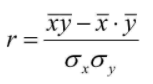

In [59]:
############################################
# Расчет линейнного коэффициента корреляции.
############################################

def correlate(a, b):

  ma = a.mean() 
  mb = b.mean() 
  mab = (a*b).mean() 
  sa = a.std() 
  sb = b.std() 
  
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

In [60]:
#####################################################################################
# Расчитываем корелляцию между базовым рядом и предсказанным  с разныс сдвигом шагов.
#####################################################################################


def showCorr(channels, corrSteps, predVal, yValUnscaled):

    '''
        channels - по каким каналам отображать корреляцию
        corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции

    '''        
  # Проходим по всем каналам
    for ch in channels:
      corr = [] 
      yLen = yValUnscaled.shape[0] 

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
      for i in range(corrSteps):
        corr.append(correlate(yValUnscaled[:yLen-i], predVal[i:]))   
        own_corr = [] 

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
      for i in range(corrSteps):
        own_corr.append(correlate(yValUnscaled[:yLen-i], yValUnscaled[i:]))  

    # Отображаем график коррелций для данного шага
      plt.figure(figsize=(14,7))
      plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
      plt.plot(own_corr, label='Эталон')

    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

In [32]:
############
# Callbacks.
############

path = 'C:/Users/user/Desktop/Employers/ServiceSoft(СофтИнжиниринг)/2_Для практического задания/'
checkpoint = ModelCheckpoint(path + 'base_model.hdf5', verbose=1, monitor='val_log_cosh', save_best_only=True, mode='auto')
earlystop = EarlyStopping(monitor='val_log_cosh', patience=10, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

## Проверка на дневных данных

In [42]:
model_base = create_model()

In [39]:
# model_base.load_weights(path + 'base_model.hdf5')

In [44]:
# обучение модели
history = model_base.fit(
        X, y, epochs=50, batch_size=1, verbose=1,
        validation_split=0.15,
        callbacks = callbacks_list,
        shuffle = True
)

Epoch 1/50
 991/1019 [============================>.] - ETA: 0s - loss: 9.3258 - log_cosh: 8.7069
Epoch 00001: val_log_cosh improved from inf to 2.46262, saving model to C:/Users/user/Desktop/Employers/ServiceSoft(СофтИнжиниринг)/2_Для практического задания\base_model.hdf5
1019/1019 [==============================] - 4s 2ms/step - loss: 9.1312 - log_cosh: 8.5139 - val_loss: 3.0870 - val_log_cosh: 2.4626
Epoch 2/50
 999/1019 [============================>.] - ETA: 0s - loss: 2.6053 - log_cosh: 2.0157
Epoch 00002: val_log_cosh did not improve from 2.46262
1019/1019 [==============================] - 2s 2ms/step - loss: 2.6079 - log_cosh: 2.0179 - val_loss: 3.1686 - val_log_cosh: 2.5389
Epoch 3/50
1006/1019 [============================>.] - ETA: 0s - loss: 2.5033 - log_cosh: 1.9204
Epoch 00003: val_log_cosh improved from 2.46262 to 1.14635, saving model to C:/Users/user/Desktop/Employers/ServiceSoft(СофтИнжиниринг)/2_Для практического задания\base_model.hdf5
1019/1019 [==================

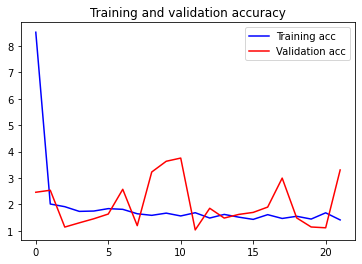

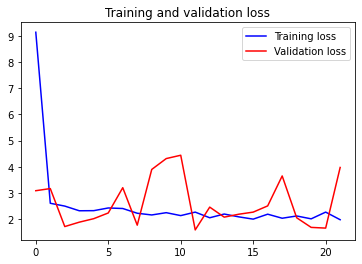

In [47]:
show_losses(history)

In [51]:
# прогноз (на всем тестовом множестве)
predictions = model_base.predict(X, verbose=1) 

38/38 [==============================] - 1s 2ms/step


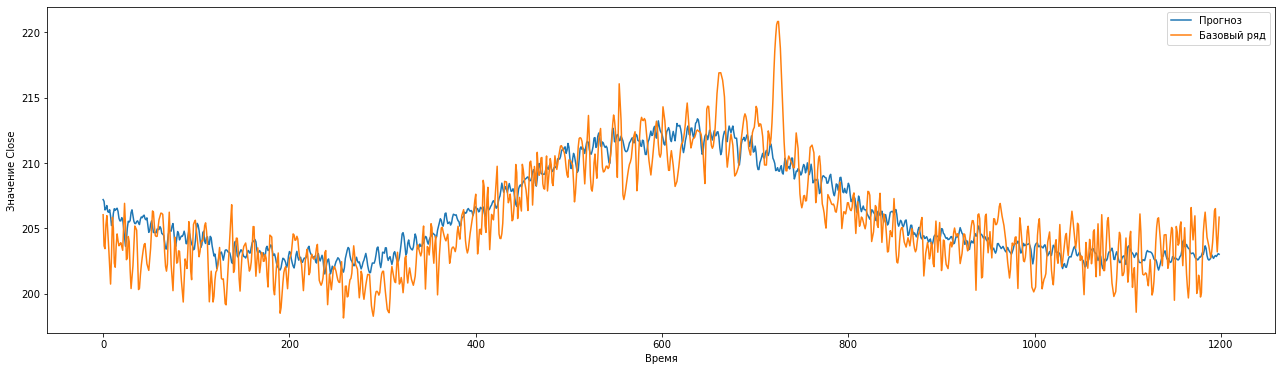

In [54]:
showPredict(0,1199,0,predictions,y)

In [55]:
pred = predictions.reshape(predictions.shape[0])

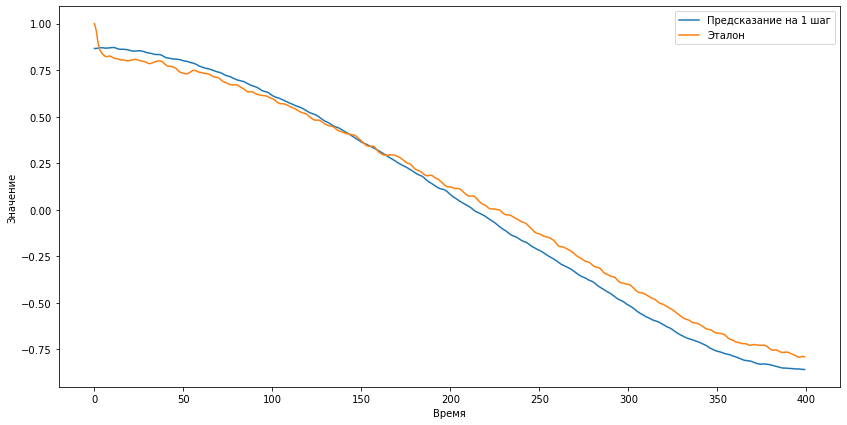

In [61]:
showCorr([0], 400, pred,y)

**На проверочных данных базовая модель очень даже неплохо делает предсказания. График корелляции так же очень близок к идеальному.**

## Проверка на обучающих данных

In [141]:
# обучение модели
history = model.fit(
        X, y, epochs=50, batch_size=1, verbose=1,
        validation_split=0.15,
        callbacks = callbacks_list,
        shuffle = True
)

Epoch 1/50
7347/7349 [============================>.] - ETA: 0s - loss: 2.8574 - log_cosh: 2.2630
Epoch 00001: val_log_cosh improved from inf to 2.33652, saving model to C:/Users/user/Desktop/Employers/ServiceSoft(СофтИнжиниринг)/2_Для практического задания\base_model.hdf5
7349/7349 [==============================] - 13s 2ms/step - loss: 2.8568 - log_cosh: 2.2625 - val_loss: 2.9698 - val_log_cosh: 2.3365
Epoch 2/50
7343/7349 [============================>.] - ETA: 0s - loss: 2.4253 - log_cosh: 1.8398
Epoch 00002: val_log_cosh improved from 2.33652 to 0.94552, saving model to C:/Users/user/Desktop/Employers/ServiceSoft(СофтИнжиниринг)/2_Для практического задания\base_model.hdf5
7349/7349 [==============================] - 12s 2ms/step - loss: 2.4249 - log_cosh: 1.8395 - val_loss: 1.4775 - val_log_cosh: 0.9455
Epoch 3/50
7337/7349 [============================>.] - ETA: 0s - loss: 2.3186 - log_cosh: 1.7332
Epoch 00003: val_log_cosh did not improve from 0.94552
7349/7349 [================

In [142]:
# сохранение последних весов и загрузка лучших
#model.save(path + 'base_model_10000.hdf5')
#model.load_weights(path + 'base_model_10000.hdf5')              

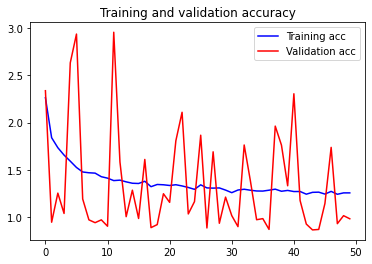

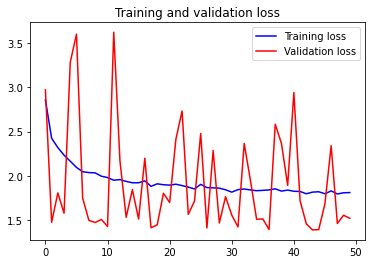

In [143]:
show_losses(history)

In [144]:
# прогноз (на всем тестовом множестве)
predictions = model.predict(X, verbose=1) 

271/271 [==============================] - 0s 1ms/step


In [145]:
predictions.shape

(8646, 1)

In [146]:
y.shape

(8646,)

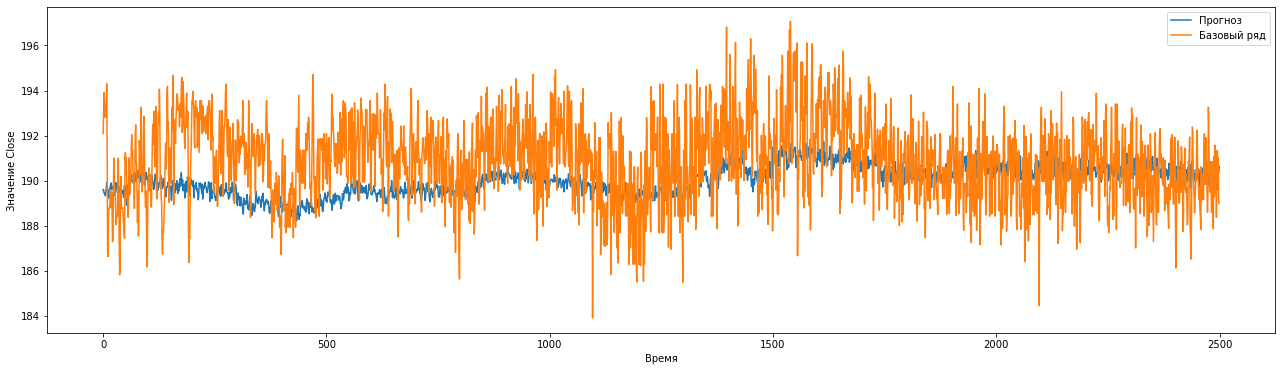

In [150]:
showPredict(0,2500,0,predictions,y)

In [153]:
pred = predictions.reshape(predictions.shape[0])

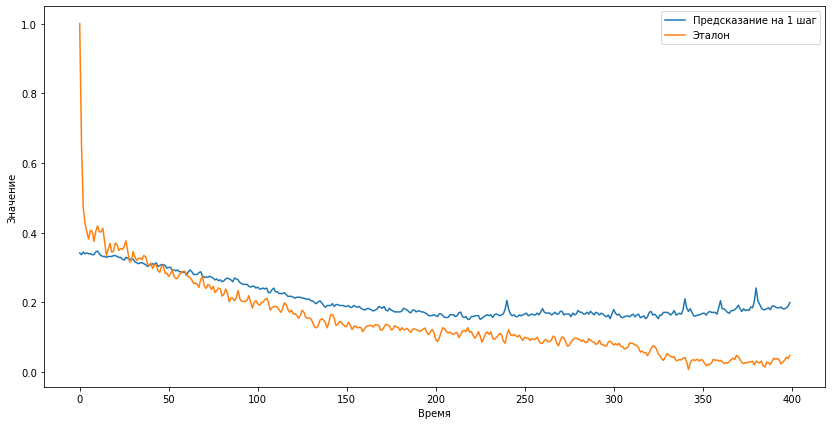

In [156]:
showCorr([0], 400, pred,y)

**На обучающих данных график предсказания выглядет куда хуже и корреляция очень низкая.**